# Zero-Dimensional Energy Balance Model

## Overview
This notebook implements a **Zero-Dimensional Energy Balance Model** to simulate the Earth's climate states. Unlike simple models that assume constant parameters, this model incorporates two critical non-linear feedbacks:

1.  **Ice-Albedo Feedback:** The planet's reflectivity (albedo) changes with temperature as ice sheets grow or melt.
2.  **Greenhouse Effect (OLR):** Outgoing Longwave Radiation is parameterized as a function of both Temperature and $CO_2$ concentration.

The model is built on the conservation of energy:

$$ \frac{dE}{dt} = \text{Energy}_{in} - \text{Energy}_{out} $$

We seek **Equilibrium** states where $\frac{dE}{dt} = 0$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.interpolate import interp1d
from dataclasses import dataclass

plt.style.use('seaborn-v0_8-whitegrid')

## Model Configuration: 

In scientific modeling, it is best practice to separate **Parameters** (constants that define the system) from **State Variables** (quantities that change, like Temperature).

We use a `dataclass` to organize our parameters. 
* **Why?** It groups related variables (like solar constant, albedo thresholds) into a single object.
* **Benefit:** Instead of passing 10 separate arguments to a function (which is error-prone), we pass one `params` object.

In [6]:
SIGMA = 5.67e-8  # Stefan-Boltzmann constant (W / m^2 / K^4)

@dataclass
class EBMParameters:
 
    L_star: float = 1361.0 / 4.0 # Solar Parameter (W/m^2)
    albedo_default: float = 0.30 # Base reflectivity
    emissivity: float = 1.0 # Blackbody efficiency
    
    # Note: We interpret this value as ppm (or microbars)
    # 400.0 corresponds to Modern Earth
    co2_pressure: float = 400.0
    
    T_eq: float = 315.0 # Equatorial Temperature (K)
    delta_T: float = 60.0 # Equator-to-Pole Gradient (K)
    
    T_i: float = 250.0 # Threshold: Ice-covered below this T
    T_o: float = 280.0 # Threshold: Ice-free above this T
    alpha_ice: float = 0.7 # Albedo of Ice
    alpha_ocean: float = 0.3 # Albedo of Ocean

## OLR Parameterization (The Greenhouse Effect)

Instead of the simple Stefan-Boltzmann law ($OLR = \epsilon \sigma T^4$), we use a polynomial fit derived from detailed radiative transfer models. This allows OLR to depend on both **Temperature** and **$CO_2$**.

$$ OLR(T, CO_2) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 $$

Where $x$ is a normalized temperature. The coefficients $a_i$ change based on the logarithm of $CO_2$ pressure.

**A Note on Units:**
The original parameterization describes the input as the "pressure of $CO_2$ in isolation." 
For this model to reproduce Modern Earth conditions correctly (warm state), we interpret the input units as **ppm** (or partial pressure in microbars, where 1 $\mu$ bar $\approx$ 1 ppm). 

* **Input 400:** Corresponds to Modern Earth (400 ppm).
* **Input 280:** Corresponds to Pre-Industrial (280 ppm).

In [7]:
# Reference temperatures for normalization
T_REF = 280.0
T_SCALE = 50.0

# CO2 partial pressures (Pa) mapped to Polynomial Coefficients
COEFFICIENT_DATA = {
    1.0:      [273.64, 129.45, -23.005, -24.558],
    10.0:     [261.53, 126.63, -15.683, -20.914],
    100.0:    [247.92, 120.72, -9.6234, -16.334],
    1000.0:   [231.35, 111.94, -3.4677, -11.163],
    10000.0:  [205.21, 97.516,   7.7354, -1.9642],
    100000.0: [150.83, 61.94,   21.96,    13.443],
    200000.0: [125.16, 44.672,  23.01,    15.982]
}

# Pre-computation of interpolators
_co2_levels = sorted(COEFFICIENT_DATA.keys())
_log_co2_levels = np.log(_co2_levels)
_coeffs_by_order = np.array([COEFFICIENT_DATA[p] for p in _co2_levels]).T
_interpolators = [
    interp1d(_log_co2_levels, row, kind='linear', fill_value='extrapolate')
    for row in _coeffs_by_order
]

def calculate_olr_flux(co2_pressure, temperature):
    """Calculates OLR given CO2 pressure (Pa) and Temperature (K)."""
    t_norm = (temperature - T_REF) / T_SCALE
    
    if co2_pressure <= 0:
        raise ValueError("CO2 pressure must be positive.")
        
    log_co2 = np.log(co2_pressure)
    coeffs = [func(log_co2) for func in _interpolators]
    
    # Polynomial: a0 + a1*x + a2*x^2 + a3*x^3
    return np.polyval(coeffs[::-1], t_norm)

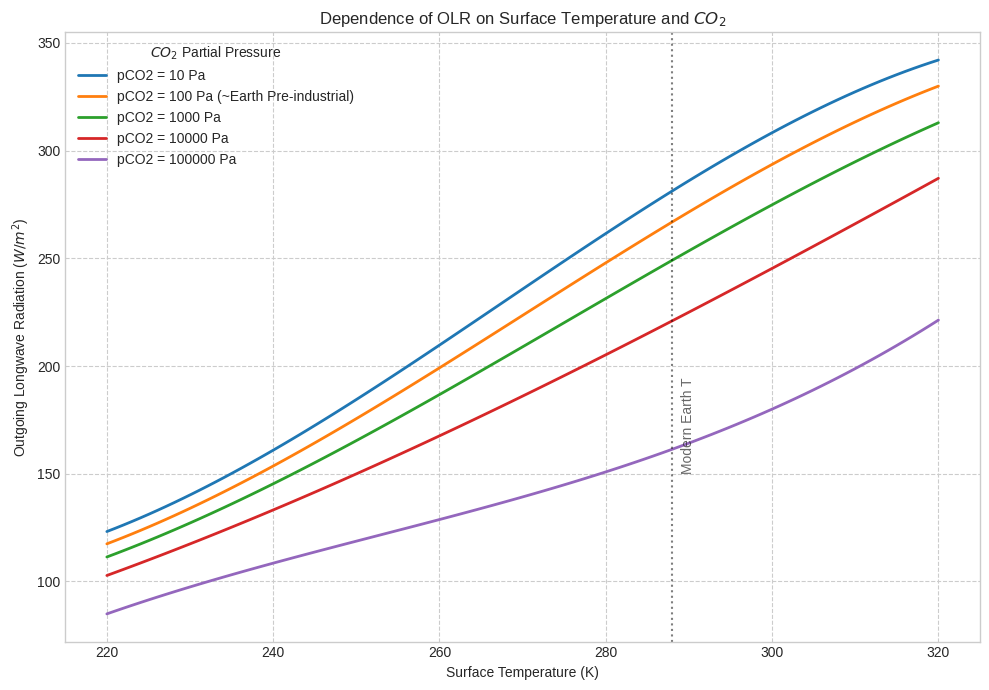

In [8]:
def run_analysis():
    # Define the range of temperatures to analyze
    temperatures = np.linspace(220, 320, 100) # Kelvin
    
    co2_scenarios = [10, 100, 1000, 10000, 100000] 
    
    plt.figure(figsize=(10, 7))
    
    for p_co2 in co2_scenarios:
        
        olr_values = [calculate_olr_flux(p_co2, T) for T in temperatures]
    
        label_text = f"pCO2 = {p_co2} Pa"
        if p_co2 == 100:
             label_text += " (~Earth Pre-industrial)"
        
        plt.plot(temperatures, olr_values, linewidth=2, label=label_text)

    plt.title(f"Dependence of OLR on Surface Temperature and $CO_2$")
    plt.xlabel("Surface Temperature (K)")
    plt.ylabel(f"Outgoing Longwave Radiation ($W/m^2$)")
    plt.grid(True, which='both', linestyle='--')
    plt.legend(title=f"$CO_2$ Partial Pressure")
    
    plt.axvline(288, color='k', linestyle=':', alpha=0.5)
    plt.text(289, 150, "Modern Earth T", rotation=90, verticalalignment='bottom', alpha=0.7)

    plt.tight_layout()
    plt.show()

run_analysis()

## Data Assimilation & State-Dependent Albedo

The 0D model simulates a single "Global Mean Temperature" ($T_{global}$). However, albedo depends on the **local** temperature (ice forms at poles, not the equator). 

To solve this, we assume an analytical profile for temperature vs. latitude:
$$ T(\phi) = T_{eq} - \Delta T \sin^2(\phi) $$

We need the equatorial temperature ($T_{eq}$) to know where the ice line is. But the solver only gives us the global average ($T_{global}$). By integrating the profile over the sphere, we find:

$$ T_{global} = T_{eq} - \frac{1}{3} \Delta T $$

Therefore, to find $T_{eq}$ from $T_{global}$, we use:
$$ T_{eq} = T_{global} + \frac{\Delta T}{3} $$

In [9]:
def temperature_profile(lat_rad, T_eq, delta_T, n=2):
    """Analytical Temperature Profile: T(phi) = T_eq - delta_T * sin^n(phi)"""
    return T_eq - delta_T * (np.sin(lat_rad) ** n)

def calculate_dynamic_albedo(T_global, params: EBMParameters):
    """
    Calculates the Global Albedo by integrating over the sphere, 
    given a Global Mean Temperature.
    """

    # Reconstruct T_eq from T_global (Inverting the geometric average)
    reconstructed_T_eq = T_global + (params.delta_T / 3.0)
    
    # Define local albedo rule 
    def local_albedo_rule(lat_rad):

        T_loc = temperature_profile(lat_rad, reconstructed_T_eq, params.delta_T, n=2)
        
        if T_loc <= 273.15:
            return params.alpha_ice
        else:
            return params.alpha_ocean
            
    # Integrate Albedo * cos(phi) over the sphere
    # limits: -pi/2 (South Pole) to pi/2 (North Pole)
    numerator, _ = integrate.quad(lambda phi: local_albedo_rule(phi) * np.cos(phi), -np.pi/2, np.pi/2)
    
    # Divide by 2.0 (integral of cosine from -pi/2 to pi/2)
    return numerator / 2.0

def albedo_simple(T, params):
    
    if T <= params.T_i:
        return params.alpha_ice
    
    if T >= params.T_o:
        return params.alpha_ocean
    
    r = (T - params.T_o)**2/(params.T_i - params.T_o)**2

    return params.alpha_ocean + (params.alpha_ice - params.alpha_ocean)*r

## The Physics: Energy Imbalance

This is the main function of the model. It combines inputs (Solar), outputs (OLR), and feedbacks (Albedo) to calculate the net energy flow.

$$ \text{Imbalance} = L_*(1 - \alpha_{dynamic}) - OLR_{polynomial} $$

**Note:** **I DIDN'T FIND A LINE WHICH USES THIS FUNCTION!**

In [10]:
def planetary_energy_imbalance(T, params: EBMParameters, albedo_func=None, outgoing_func=None):
    """
    Calculates the instantaneous planetary energy imbalance (dE/dt).
    Returns positive if warming, negative if cooling.
    """
    # Energy In
    if albedo_func is not None:
        # Calculate state-dependent albedo
        alpha_val = albedo_func(T, params)
    else:
        alpha_val = params.albedo_default

    energy_in = params.L_star * (1.0 - alpha_val)
    
    # Energy Out
    if outgoing_func is not None:
        # Use polynomial OLR (CO2 dependent)
        # Note: We pass params.co2_pressure (ppm) to the function
        energy_out = outgoing_func(T, params.co2_pressure)
    else:
        # Fallback to Stefan-Boltzmann
        energy_out = params.emissivity * SIGMA * (T ** 4)
    
    return energy_in - energy_out

## The Inverse Solver: $T \rightarrow CO_2$

Instead of calculating `Imbalance = Energy_In - Energy_Out`, we rearrange the equilibrium condition:

$$ \text{Energy}_{In}(T) = \text{OLR}(T, CO_2) $$

For a fixed Temperature $T$:
1. Calculate the required Absorbed Solar Radiation ($ext{ASR}$). 
2. Search for the specific $CO_2$ value that makes the OLR match this ASR.

In [11]:
def calculate_co2_for_equilibrium(T, params: EBMParameters):
    """
    Given a target Global Temperature, calculates the CO2 (ppm)
    required to maintain that temperature in equilibrium.
    
    Returns None if no physical solution exists.
    """

    # Calculate Required Energy Input (ASR)
    # This is fixed for a given Temperature because Albedo depends only on T.
    albedo = albedo_simple(T, params)
    required_olr = params.L_star * (1.0 - albedo)
    
    # Define Mismatch Function
    # We want to find p_co2 such that: OLR(T, p_co2) - required_olr = 0
    def olr_mismatch(p_co2):
        return calculate_olr_flux(p_co2, T) - required_olr
    
    # Solve for CO2
    # We search in range [1 ppm, 200,000 ppm] (1 ppm to 20%)
    try:
        # brentq is a robust root-finding method for bounded intervals
        p_co2_sol = optimize.brentq(olr_mismatch, 1.0, 200000.0)
        return p_co2_sol
    except ValueError:
        # If roots are not found (e.g., required OLR is impossible to achieve 
        # with CO2 within physical bounds), return None
        return None

## Defining Climate States: Calculating Limits

We can mathematically determine the exact Global Temperatures where the Earth transitions into a fully ice-covered ("Snowball") or fully ice-free ("Hothouse") state based on our assumed temperature profile.

### Fully Ice-Covered (Snowball) Limit
The planet becomes a Snowball when even the warmest point (the Equator) drops below the ice threshold ($T_i$).
$$ T_{eq} \le T_i $$
Substituting $T_{eq} = T_{global} + \frac{\Delta T}{3}$:
$$ T_{global} \le T_i - \frac{\Delta T}{3} $$

### Fully Ice-Free (Hothouse) Limit
The planet becomes ice-free when even the coldest point (the Pole) rises above the ocean threshold ($T_o$).
$$ T_{pole} \ge T_o $$
Since $T_{pole} = T_{eq} - \Delta T$, we have:
$$ T_{eq} \ge T_o + \Delta T $$
Substituting for $T_{eq}$ again:
$$ T_{global} + \frac{\Delta T}{3} \ge T_o + \Delta T \implies T_{global} \ge T_o + \frac{2 \Delta T}{3} $$

Snowball Earth Threshold (Global T): < 250.0 K
Ice-Free Earth Threshold (Global T): > 280.0 K


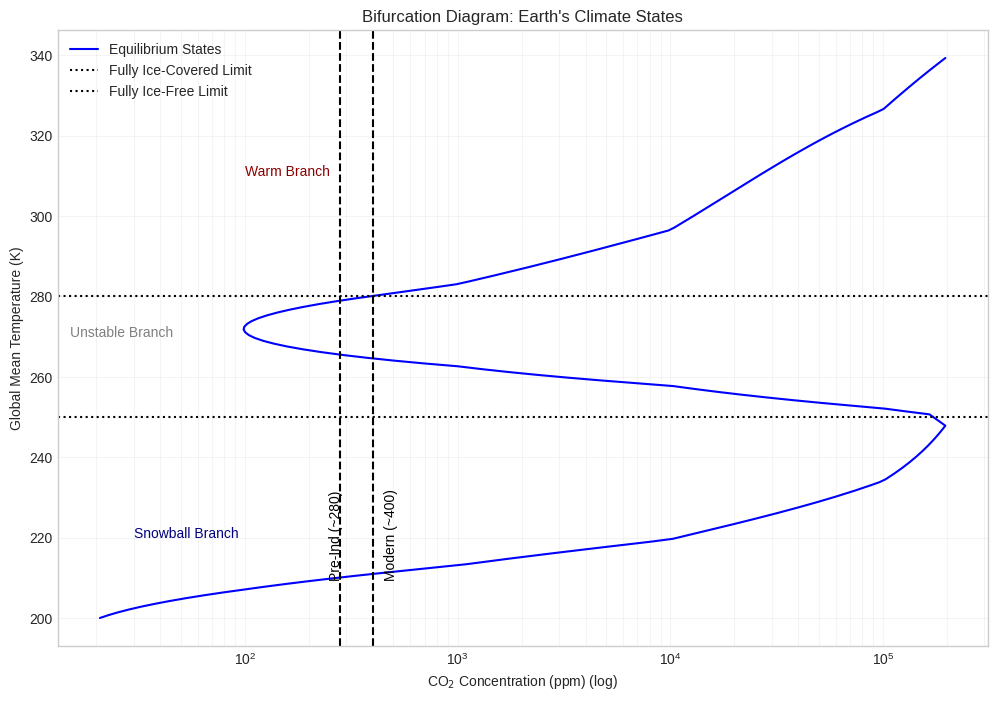

In [ ]:
def run_simulation():
    earth_params = EBMParameters()
    
    print(f"Snowball Earth Threshold (Global T): < {earth_params.T_i:.1f} K")
    print(f"Ice-Free Earth Threshold (Global T): > {earth_params.T_o:.1f} K")
    
    # Sweep Temperatures (Cold to Hot)
    # We span 200K (Snowball) to 340K (Hothouse)
    T_sweep = np.linspace(200, 340, 200)
    
    # Calculate corresponding CO2 
    valid_T = []
    valid_CO2 = []
    
    for T in T_sweep:
        p_co2 = calculate_co2_for_equilibrium(T, earth_params)
        
        if p_co2 is not None:
            valid_T.append(T)
            valid_CO2.append(p_co2)
            
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Bifurcation Curve
    plt.plot(valid_CO2, valid_T, lw=1.5, color='blue', label='Equilibrium States')

    plt.axhline(earth_params.T_i, color='black', linestyle=':', label='Fully Ice-Covered Limit')
    plt.axhline(earth_params.T_o, color='black', linestyle=':', label='Fully Ice-Free Limit')
    
    # Styling
    plt.xscale('log')
    plt.xlabel('CO$_2$ Concentration (ppm) (log)')
    plt.ylabel('Global Mean Temperature (K)')
    plt.title('Bifurcation Diagram: Earth\'s Climate States')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    # Annotations
    plt.axvline(280.0, color='black', linestyle='--')
    plt.text(250, 210, 'Pre-Ind (~280)', color='black', rotation=90)
    
    plt.axvline(400.0, color='black', linestyle='--')
    plt.text(450, 210, 'Modern (~400)', color='black', rotation=90)
    
    plt.text(30, 220, 'Snowball Branch', color='navy')
    plt.text(100, 310, 'Warm Branch', color='darkred')
    plt.text(15, 270, 'Unstable Branch', color='gray')

    plt.show()
    return valid_CO2, valid_T


valid_CO2, valid_T = run_simulation()

## Climate Sensitivity Analysis

**Equilibrium Climate Sensitivity (ECS)** is often defined as the increase in temperature resulting from a doubling of $CO_2$. 

Mathematically, this corresponds to the slope of the Bifurcation Diagram (specifically, the change in $T$ with respect to the logarithm of $CO_2$):

$$ \text{Sensitivity} \approx \ln(2) \times \frac{dT}{d \ln(CO_2)} $$

In the code below, we calculate this derivative numerically for every point on the equilibrium curve. 

**Interpretation:**
* **Low Sensitivity:** The climate is stable (Snowball or Hothouse branches).
* **High Sensitivity:** The climate is very responsive to small changes in $CO_2$.
* **Infinite Sensitivity:** Occurs at the "tipping points" (the nose of the bifurcation curve). Here, a tiny push in $CO_2$ causes the system to jump to a completely different state.

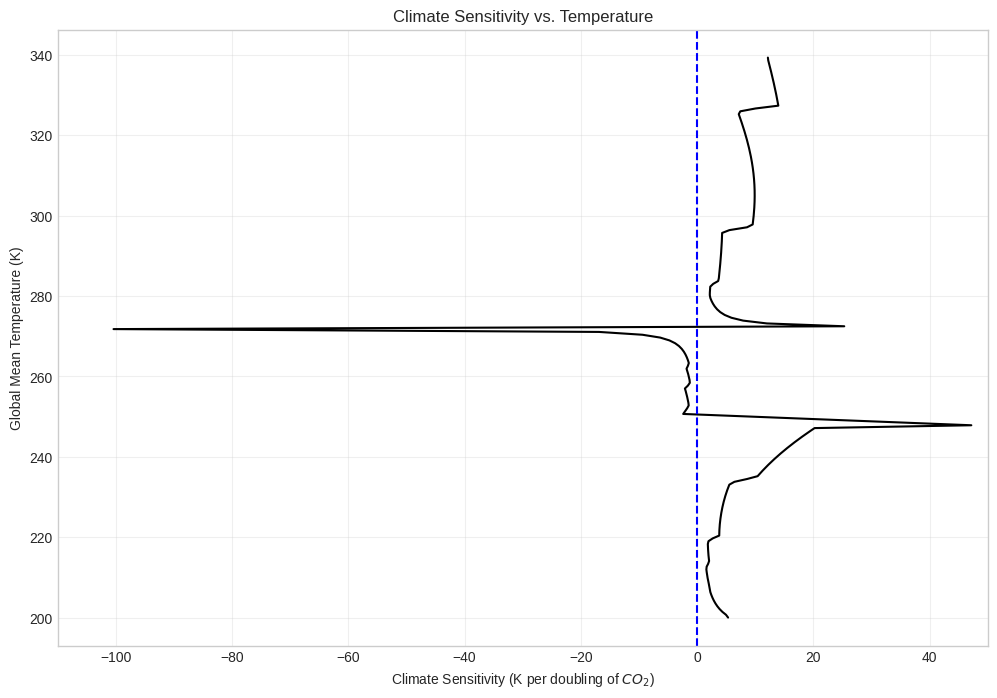

In [19]:
def analyze_sensitivity(co2_vals, temp_vals):
    """
    Calculates and plots the climate sensitivity (dT per doubling of CO2).
    Sensitivity = ln(2) * dT / d(ln CO2)
    """
    # Calculate Log CO2
    log_co2 = np.log(co2_vals)
    
    # Compute Derivative numerically (dT / d lnCO2)
    # We use gradient with respect to the array indices, then divide
    # Note: Since we swept T uniformly, calculating d(lnCO2)/dT is smoother,
    # then we invert it. 
    # Derivative = 1 / (d(lnCO2) / dT)
    
    d_lnCO2_dT = np.gradient(log_co2, temp_vals)
    
    # Invert to get dT / d(lnCO2)
    # Handle division by zero (at tipping points where slope is flat/vertical)
    with np.errstate(divide='ignore'):
        dT_dlnCO2 = 1.0 / d_lnCO2_dT
        
    # Convert to "Per Doubling" (multiply by ln(2))
    sensitivity = np.log(2) * dT_dlnCO2
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # We plot Sensitivity on X and Temperature on Y to align with the Bifurcation Diagram
    plt.plot(sensitivity, temp_vals, color='black')
    
    plt.xlabel('Climate Sensitivity (K per doubling of $CO_2$)')
    plt.ylabel('Global Mean Temperature (K)')
    plt.title('Climate Sensitivity vs. Temperature')
    plt.grid(True, alpha=0.3)
    
    # Limit X-axis to keep plot readable (sensitivity goes to infinity)
    plt.xlim(-110, 50)
    plt.axvline(0, color='blue', linestyle='--')

    plt.show()


analyze_sensitivity(valid_CO2, valid_T)